# GO/STOP! - Object Detection 시스템 만들기

object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 봅시다.

> **자율주행 시스템의 object detection 요구사항**  
>    - 사람이 카메라에 감지되면 정지  
>    - 차량이 일정 크기 이상으로 감지되면 정지

## 1. KITTI 데이터셋

tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용하겠습니다.  
KITTI 데이터셋은 자율주행을 위한 데이터셋으로, 2D object detection뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.

먼저 필요한 라이브러리를 불러옵니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

아래 코드를 통해서 KITTI 데이터셋을 다운로드합니다.

In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 **`tfds.show_examples(ds, ds_info)`** 를 통해 확인합니다.

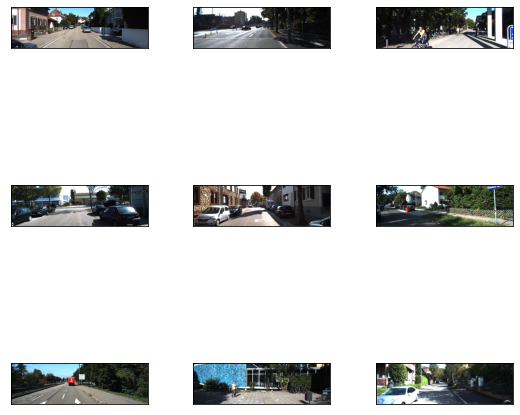

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

변수 **`ds_info`** 는 불러온 데이터셋의 정보가 포함되어 있습니다.  
> - 학습 데이터 (training data) : 7,481개  
> - 테스트 데이터 (test data) : 711개  
> - 검증 데이터 (validation data) : 423개  
> - 라벨 : alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등 

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj41/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

## 2. 데이터 직접 확인하기

**`ds_train.take(1)`** 을 통해서 데이터셋을 하나씩 뽑아볼 수 있습니다.  
이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

In [5]:
TakeDataset = ds_train.take(1)

아래의 코드를 통해 데이터셋의 이미지와 라벨을 얻을 수 있습니다.

In [17]:
for example in TakeDataset:  
    # print('='*50 + ' Example ' + '='*50)
    # print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]
    
print('='*50 + ' filename ' + '='*50)
print(filename)

================================================== filename ==================================================
004602.png


In [18]:
print('='*50 + ' image ' + '='*50)
print(image)

================================================== image ==================================================
tf.Tensor(
[[[135 124  91]
  [136 124  93]
  [144 129  92]
  ...
  [255 255 255]
  [254 255 255]
  [253 255 255]]

 [[134 123  93]
  [133 122 103]
  [140 125 105]
  ...
  [252 255 255]
  [253 255 255]
  [255 255 255]]

 [[148 124  92]
  [147 124 104]
  [147 128 109]
  ...
  [250 255 255]
  [250 255 255]
  [250 255 255]]

 ...

 [[ 36  35  45]
  [ 37  35  41]
  [ 36  37  38]
  ...
  [ 26  38  50]
  [ 30  38  52]
  [ 33  38  52]]

 [[ 36  36  38]
  [ 36  38  39]
  [ 36  39  39]
  ...
  [ 25  31  35]
  [ 30  35  34]
  [ 36  36  38]]

 [[ 48  40  37]
  [ 50  43  39]
  [ 40  46  39]
  ...
  [ 30  28  36]
  [ 28  30  32]
  [ 28  33  34]]], shape=(375, 1242, 3), dtype=uint8)


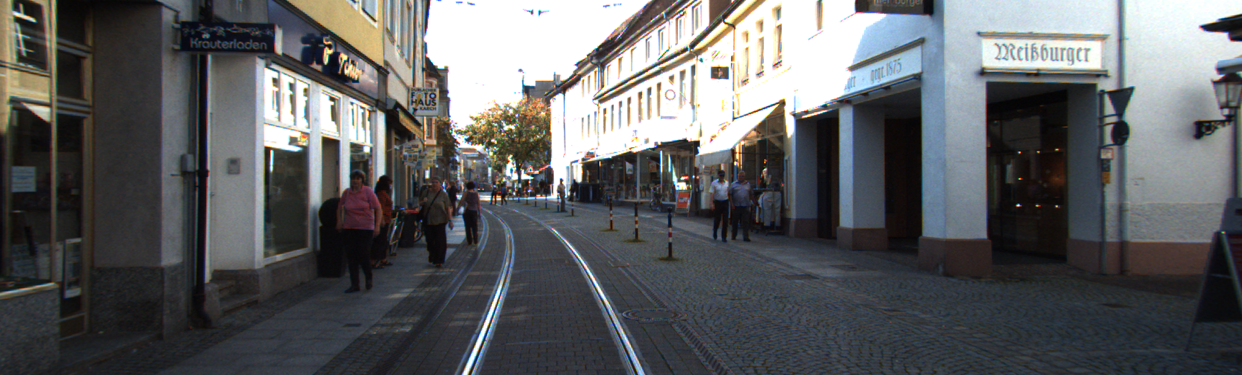

In [19]:
img = Image.fromarray(image.numpy())
img

In [20]:
print('='*50 + ' objects ' + '='*50)
print(objects)

================================================== objects ==================================================
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-2.21,  1.77,  1.51,  1.38,  1.31], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.34184   , 0.36522543, 0.51861334, 0.38880837],
       [0.21797334, 0.26977456, 0.55328   , 0.31044284],
       [0.28346667, 0.34111112, 0.53752   , 0.3671739 ],
       [0.35176   , 0.570781  , 0.55690664, 0.5912963 ],
       [0.35696   , 0.5866103 , 0.5513333 , 0.6079066 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.58, 0.67, 0.87],
       [1.7 , 0.7 , 0.69],
       [1.67, 0.62, 0.95],
       [1.92, 0.64, 1.08],
       [1.83, 0.77, 1.01]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.48,  1.78, 17.79],
       [-3.58,  1.63, 10.17],
       [-3.24,  1.69, 13.25],
       [ 2.86,  1.76, 18.61],
       [ 3.43,  1.72,

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.

| Values | Name | Description |
|:----------:|:----------|:----------|
| 1 | type | 객체 type 설명 : 'Car', 'Van', 'Truck', 'Pedestrian, 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'|
| 1 | truncated | 이미지 경계를 벗어난 정도 : (float) 0(잘리지 않음) ~ 1(잘림) |
| 1 | occluded | 폐색 상태의 정도 : (integer) 0(완전히 보임), 1(부분적으로 가려짐), 2(거의 가려짐), 3(알 수 없음) |
| 1 | alpha | 물체의 관찰 각도 : -π ~ π |
| 4 | bbox | 2D 이미지의 바운딩 박스 : 왼쪽, 위쪽, 오른쪽, 아래쪽의 픽셀 좌표 |
| 3 | dimensions | 3D 객체의 차원 : 높이, 너비, 길이 (m) |
| 3 | location | 카메라 좌표의 3D 객체 위치 : x, y, z (m) |
| 1 | rotation_y | 카메라 좌표에서 y축을 중심으로 회전 : -π ~ π |
| 1 | score | 결과 : (float) 높을수록 좋다. |

예시) 데이터셋 004602.png 에 대한 설명  
1. type : [3, 3, 3, 3, 3]
2. truncated : [0., 0., 0., 0., 0.]
3. occluded : [0, 0, 0, 0, 0]
4. alpha : [-2.21,  1.77,  1.51,  1.38,  1.31]
5. bbox : [ [0.34184   , 0.36522543, 0.51861334, 0.38880837],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[0.21797334, 0.26977456, 0.55328   , 0.31044284],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[0.28346667, 0.34111112, 0.53752   , 0.3671739 ],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[0.35176   , 0.570781  , 0.55690664, 0.5912963 ],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[0.35696   , 0.5866103 , 0.5513333 , 0.6079066 ] ]  
6. dimensions : [ [1.58, 0.67, 0.87],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.7 , 0.7 , 0.69],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.67, 0.62, 0.95],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.92, 0.64, 1.08],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.83, 0.77, 1.01] ]  
7. location : [ [-3.48,  1.78, 17.79],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[-3.58,  1.63, 10.17],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[-3.24,  1.69, 13.25],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[ 2.86,  1.76, 18.61],  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[ 3.43,  1.72, 18.68] ]  
8. rotation_y : [-2.4 ,  1.44,  1.27,  1.53,  1.49]

아래 코드를 통해 위에서 얻은 이미지의 이미지의 바운딩 박스(bbox)를 확인할 수 있습니다.

> **visualize_bbox(input_image, object_bbox)**  
>
> KITTI 데이터셋의 이미지(1개)와 이미지['objects']의 bbox를 입력으로 주면 바운딩 박스가 표시된 이미지를 리턴합니다.

In [21]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

width: 1242  height: 375
(5, 4)
[453.61 246.81 482.9  180.52]
[335.06 293.26 385.57 167.52]
[423.66    268.7     456.03    173.43001]
[708.91 243.09 734.39 166.16]
[728.57    241.14    755.01996 168.25002]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F213003D690>


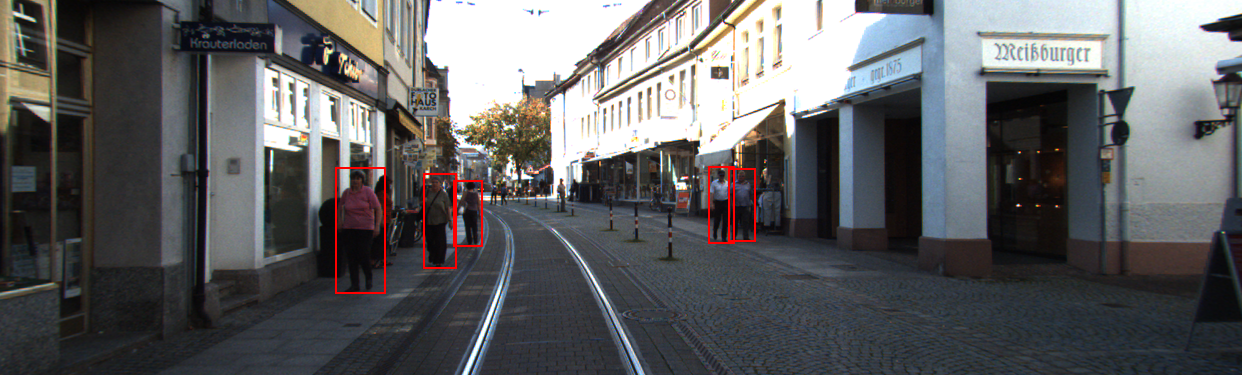

In [22]:
visualize_bbox(img, objects['bbox'].numpy())

## 3. RetinaNet

미리 학습시킨 라이브러리인 RetinaNet이라는 1-stage detector를 가져와 원본 데이터셋에 학습시킵니다.

1-stage detector 모델은 속도는 빠르지만 성능이 낮은 문제를 가지고 있습니다.  
이를 해결하기 위해 RetinaNet에서는 focal loss 와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용합니다.

### 1) Focal Loss

focal loss는 물체와 배경을 담고 있는 모든 그리드에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다.  
대부분의 이미지에는 물체보다 배경이 많습니다. 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data 라고 할 수 있습니다.  
이렇게 너무 많은 배경 class에 압도되지 않도록 계산하는 loss가 focal loss입니다.

### 2) FPN (Feature Pyramid Network)

FPN 은 feature를 피라미드처럼 쌓아서 사용하는 방식입니다.  

*CNN 백본 네트워크에서 입력 이미지와 먼 모델의 뒷쪽의 feature map일 수록 넓은 범위의 정보를 담고 있고, 입력이미지와 가까운 앞쪽 레이어의 feature map일 수록 좁은 범위의 정보를 담고 있습니다. 이를 __receptive field__ 라고 합니다. 즉, 레이어가 깊어질 수록 넓은 범위의 정보(receptive field)를 가지게 됩니다.*

FPN 은 백본 네트워크의 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다.  
레이어가 깊어질 수록 receptive filed가 넓어지는데, FPN을 사용하면 넓게 보는 것과 좁게 보는 것을 같이 할 수 있습니다.

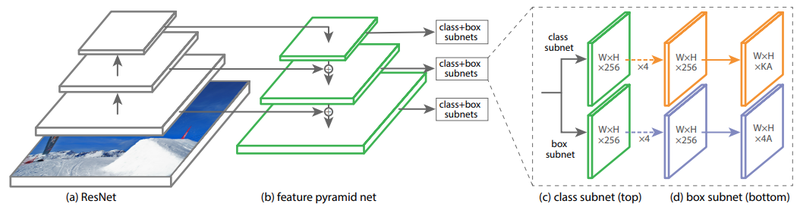

위 그림은 RetinaNet 에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림입니다.

## 4. 데이터 포맷 변경

KITTI 데이터셋을 RetinaNet을 학습시키기 위해서는 KITTI 데이터셋 포맷을 csv 형태로 변경해야합니다.

### 1) 클래스 및 바운딩 박스 정보 추출

아래와 같이 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 csv 파일을 작성해야 합니다.

> **데이터셋 형식**  
> `image's path,x1,y1,x2,y2,class_name`
>
> **예시**  
> `/data/imgs/img_001.jpg,837,346,981,456,cow`  
> `/data/imgs/img_002.jpg,215,312,279,391,cat`  
> `/data/imgs/img_002.jpg,22,5,89,84,bird`  
> `...`  

> **csv로 파일을 저장하는 코드 예시**  
>
> `df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)`
> `df_test.to_csv('./kitti_test.csv', sep=',',index = False, header=False)`

> `tqdm` 은 루프문의 상태에 따라 콘솔에 진행 상황바를 표시할 수 있는 라이브러리입니다.

아래 코드를 통해 csv 파일을 생성합니다.

> **parse_dataset(dataset, img_dir, total)**
>
> KITTI 데이터셋, 데이터셋이 저장된 경로 그리고 데이터셋의 개수를 입력으로 주면 위와 같은 데이터셋 형식을 가진 csv파일을 생성합니다.

In [24]:
import os

data_dir = os.getenv('HOME')+'/aiffel/cv/03_project/data'
img_dir = os.getenv('HOME')+'/kitti_images'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

훈련 데이터셋에 **`parse_dataset()`** 을 적용하여 dataframe을 생성합니다.

In [25]:
train_csv_path = data_dir + '/kitti_train.csv'

In [10]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

  0%|          | 0/6347 [00:00<?, ?it/s]/home/aiffel-dj41/anaconda3/envs/treebit/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 6347/6347 [16:51<00:00,  6.27it/s]


테스트 데이터셋에 `parse_dataset()`을 적용하여 dataframe을 생성합니다.

In [26]:
test_csv_path = data_dir + '/kitti_test.csv'

In [11]:
df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

  0%|          | 0/711 [00:00<?, ?it/s]/home/aiffel-dj41/anaconda3/envs/treebit/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 711/711 [02:03<00:00,  5.74it/s]


### 2) 클래스 맵핑

데이터 셋에서 class는 문자열로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 class를 표시해야 합니다.  
아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만듭니다.

> **클래스 맵핑 형식**  
> `class_name, id`  
>
> **예시**  
> `cow,0`  
> `cat,1`  
> `bird,2`  

In [27]:
def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

In [28]:
class_txt_path = data_dir + '/classes.txt'

In [12]:
save_class_format(class_txt_path)

## 5. 셋팅

아래 코드를 실행하여 위에서 변환한 데이터셋을 RetinaNet 모델에 학습시킵니다.

*학습이 잘 되기 위해서는 환경에 따라 batch_size나 worker, epoch를 조절해야 합니다.  
훈련 이미지 크기 또는 batch_size가 너무 크면 OOM 에러가 날 수 있으니 적절히 조정해야 합니다.*

In [10]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/cv/03_project && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-27 00:00:52.495653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 00:00:53.602441: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 00:00:53.603134: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 00:00:53.628421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 00:00:53.628862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 00:00:53.628889: I tensorflow/stream_executor/platform/default/d

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "retinanet"
_________________________________________________________________________________

2021-04-27 00:00:56.799886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-27 00:00:56.818827: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2021-04-27 00:01:02.772446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynam

195/195 [==============================] - 62s 316ms/step - loss: 1.9878 - regression_loss: 1.5828 - classification_loss: 0.4050

Epoch 00006: saving model to ./snapshots/resnet50_csv_06.h5
Epoch 7/50
195/195 [==============================] - 61s 313ms/step - loss: 1.8016 - regression_loss: 1.4196 - classification_loss: 0.3820

Epoch 00007: saving model to ./snapshots/resnet50_csv_07.h5
Epoch 8/50
195/195 [==============================] - 62s 316ms/step - loss: 1.7646 - regression_loss: 1.3933 - classification_loss: 0.3713

Epoch 00008: saving model to ./snapshots/resnet50_csv_08.h5
Epoch 9/50
195/195 [==============================] - 63s 321ms/step - loss: 1.7864 - regression_loss: 1.4032 - classification_loss: 0.3832

Epoch 00009: saving model to ./snapshots/resnet50_csv_09.h5
Epoch 10/50
195/195 [==============================] - 58s 298ms/step - loss: 1.6733 - regression_loss: 1.3172 - classification_loss: 0.3561

Epoch 00010: saving model to ./snapshots/resnet50_csv_10.h5
Epoch

195/195 [==============================] - 65s 330ms/step - loss: 1.1803 - regression_loss: 0.8985 - classification_loss: 0.2818

Epoch 00028: saving model to ./snapshots/resnet50_csv_28.h5
Epoch 29/50
195/195 [==============================] - 63s 321ms/step - loss: 1.0565 - regression_loss: 0.8104 - classification_loss: 0.2462

Epoch 00029: saving model to ./snapshots/resnet50_csv_29.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 30/50
195/195 [==============================] - 62s 316ms/step - loss: 1.0775 - regression_loss: 0.8161 - classification_loss: 0.2614

Epoch 00030: saving model to ./snapshots/resnet50_csv_30.h5
Epoch 31/50
195/195 [==============================] - 62s 316ms/step - loss: 1.0802 - regression_loss: 0.8261 - classification_loss: 0.2540

Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5
Epoch 32/50
195/195 [==============================] - 62s 316ms/step - loss: 1.1093 - regression_loss: 0.8580 - classifica


Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.
Epoch 49/50
195/195 [==============================] - 57s 292ms/step - loss: 1.0472 - regression_loss: 0.7961 - classification_loss: 0.2511

Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5
Epoch 50/50
195/195 [==============================] - 57s 291ms/step - loss: 1.1199 - regression_loss: 0.8640 - classification_loss: 0.2559

Epoch 00050: saving model to ./snapshots/resnet50_csv_50.h5

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.999999010570977e-19.


아래 코드를 실행하여 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합니다.

In [11]:
!cd ~/aiffel/cv/03_project && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 00:53:33.899155: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 00:53:35.469795: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 00:53:35.473759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 00:53:35.497935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 00:53:35.498413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 00:53:35.498437: I tensorflow/stream_executor/platform/default/d

## 6. 시각화

아래 코드를 사용하여 위에서 변환한 모델을 load 하도록 하겠습니다.

*일정 점수 이하는 경우를 제거하도록 하겠습니다.*

In [40]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# warning 무시
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

dir_path = os.getenv('HOME') + '/aiffel/cv/03_project'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


아래 코드를 실행하여 load한 모델을 통해 추론을 하고 시각화하도록 하겠습니다.

> **inference_on_image(model, img_path, visualize)**
>
> load한 모델, 추론할 이미지의 경로 그리고 이미지의 바운딩표시유무에 대한 값을 입력으로 추론한 결과에 대해 시각화합니다.

In [71]:
# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", size_limit=300, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    person = False
    car = False
    
    color_map = {
        0: (0, 0, 255), # car : blue
        1: (255, 0, 0) # person : red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < 0.5:
                break
            # print(box)
            b = box.astype(int)
            width = box[2] - box[0]
            height = box[3] - box[1]
            draw_box(draw, b, color=color_map[label])
            
            if label == 1:
                person = True
            if label == 0 and (width >= size_limit or height >= size_limit):
                car = True
             
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()     
        
    return person, car

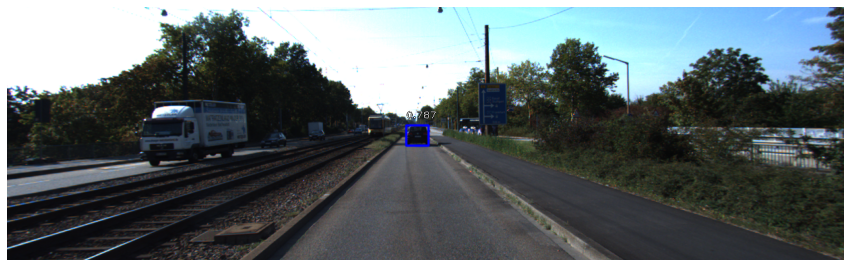

In [72]:
import os

img_path = os.getenv('HOME')+'/aiffel/cv/03_project/test_set/go_1.png'
_, _ = inference_on_image(model, img_path=img_path)

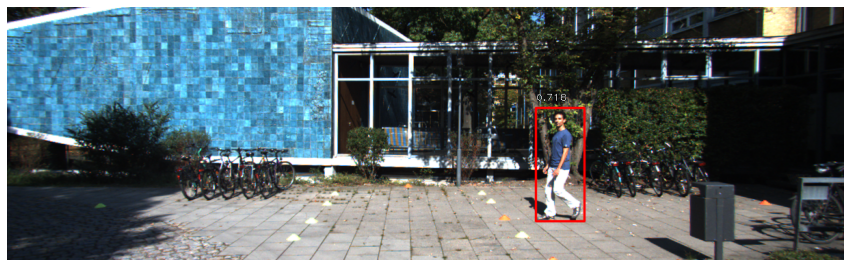

In [73]:
img_path = os.getenv('HOME')+'/aiffel/cv/03_project/test_set/stop_1.png'
_, _ = inference_on_image(model, img_path=img_path)

## 7. 자율주행 시스템 만들기

위에서 만든 모델을 통해 자율주행 시스템을 만들어보도록 하겠습니다.  
자율 주행 시스템은 아래의 조건을 만족해야합니다.

> 1. 입력으로 이미지 경로를 받습니다.  
> 2. 정지 조건에 맞는 경우 "STOP", 아닌 경우 "GO" 를 반환합니다.  
> 3. 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px 이상인 경우

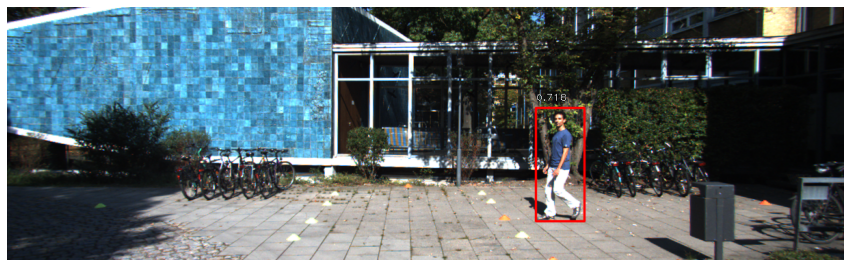

Stop


In [74]:
img_path = os.getenv('HOME')+'/aiffel/cv/03_project/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    person, car = inference_on_image(model, img_path=img_path, size_limit=size_limit)
    
    if person == True or car == True:
        return "Stop"
    else:
        return "Go"

print(self_drive_assist(img_path))  

## 8. 자율주행 시스템 평가하기

아래 `test_system()` 함수를 통해서 위에서 만든 함수를 평가합니다.  
10장에 대해 GO 와 STOP이 맞게 변환하는지 확인하고, 100점 만점으로 평가합니다.

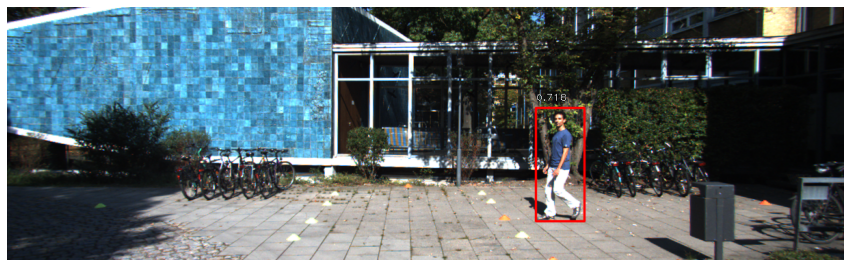

예측 : Stop, 정답 : Stop



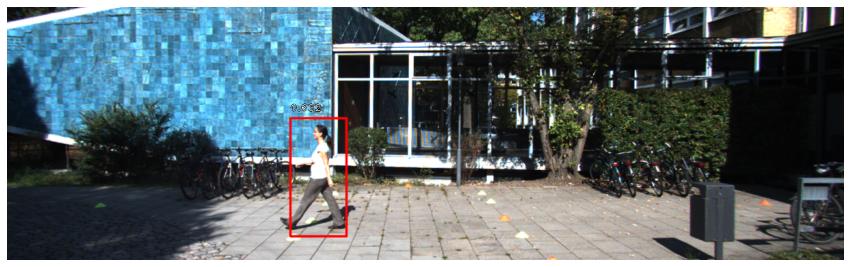

예측 : Stop, 정답 : Stop



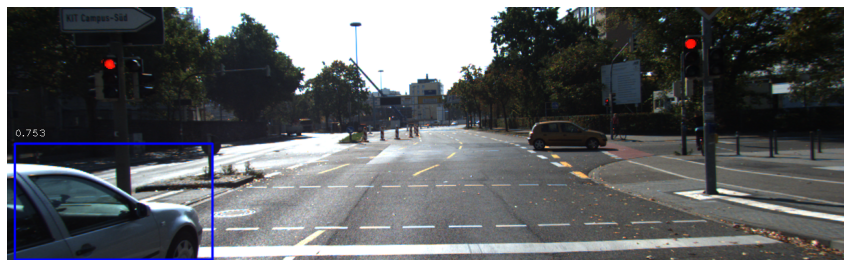

예측 : Go, 정답 : Stop



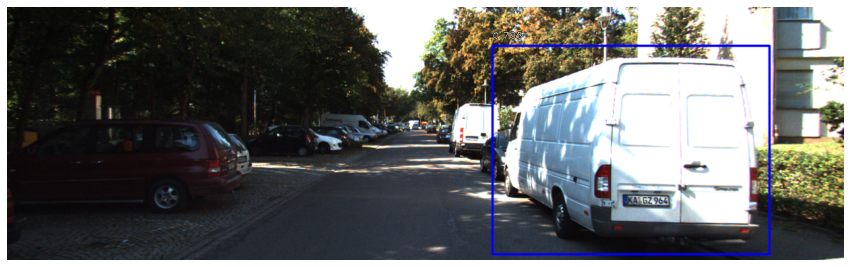

예측 : Stop, 정답 : Stop



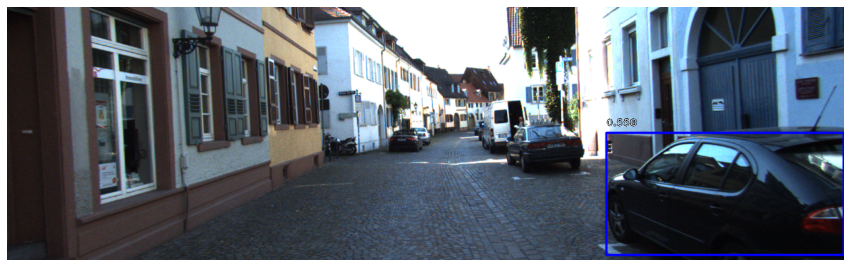

예측 : Stop, 정답 : Stop



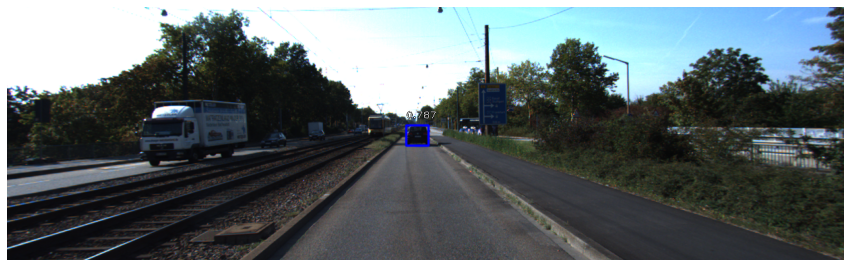

예측 : Go, 정답 : Go



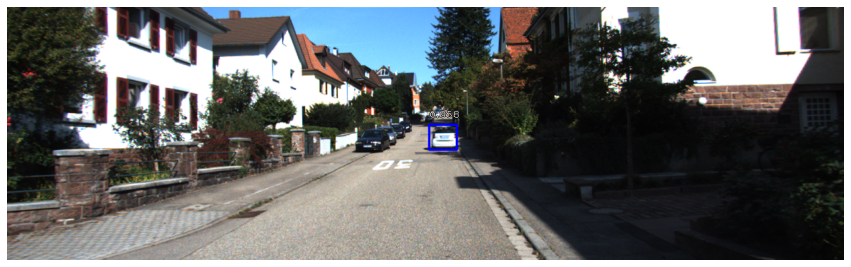

예측 : Go, 정답 : Go



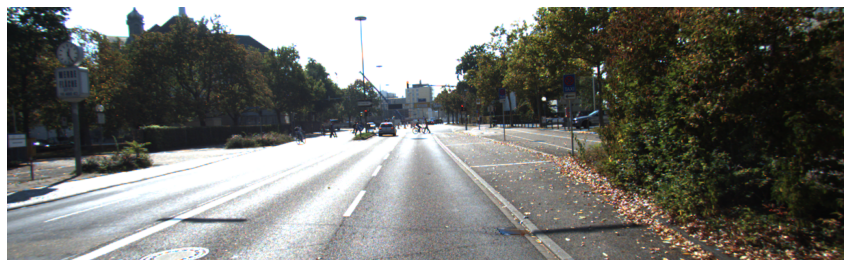

예측 : Go, 정답 : Go



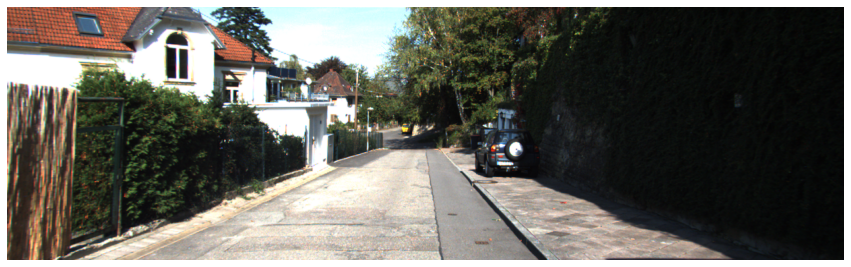

예측 : Go, 정답 : Go



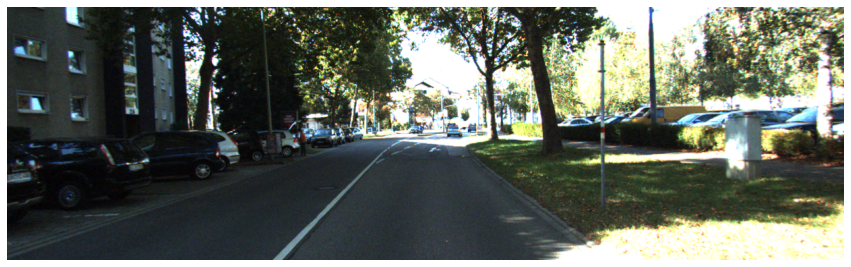

예측 : Go, 정답 : Go

90점입니다.


In [75]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/cv/03_project'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        
        print('예측 : ' + pred + ', 정답 : ' + answer)
        print()
        
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

## 9. 루브릭

**1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.**  

    KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였습니다.

**2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.**  

    바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였습니다.

**3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.**  

    테스트 수행결과 90% 이상의 정확도를 보였다. (90점)